In [1]:
import numpy as np
import napiod
from napiod.model import Constants
import matplotlib.pyplot as plt 

In [2]:
AGENT_DIRECTION = -1  # The agents is selling

In [3]:
def balanced_transition_probabilities():
    phis = np.zeros(
        Constants.shape_of_transition_matrix(),
        dtype=float
    )   

    # Event type 1: sell market order
    phis[np.ix_(
        Constants.negative_imbalance_states(),
        [1],
        Constants.deflationary_states())
    ] = 1. / len(Constants.deflationary_states())
    phis[np.ix_(
        Constants.non_negative_imbalance_states(),
        [1],
        Constants.non_inflationary_states())
    ] = 1. / len(Constants.non_inflationary_states())

    # Event type 2: buy market order
    phis[np.ix_(
        Constants.positive_imbalance_states(),
        [2],
        Constants.inflationary_states())
    ] = 1. / len(Constants.inflationary_states())
    phis[np.ix_(
        Constants.non_positive_imbalance_states(),
        [2],
        Constants.non_deflationary_states())
    ] = 1. / len(Constants.non_deflationary_states())

    # Event type 3
    phis[np.ix_(
        np.arange(phis.shape[0]),
        [3],
        Constants.deflationary_states())
    ] = 1. / len(Constants.deflationary_states())

    # Event type 4
    phis[np.ix_(
        np.arange(phis.shape[0]),
        [4],
        Constants.inflationary_states())
    ] = 1. / len(Constants.inflationary_states())

    return phis


In [4]:
def balanced_hawkes_coefficients():
    # base rates
    nus = .2 * np.ones(napiod.model.TOTAL_NUMBER_OF_EVENT_TYPES, dtype=float)

    # impact coefficients
    alphas = np.zeros(
        Constants.shape_of_impact_coefficients(),
        dtype=float
    )
    alphas[np.ix_(
        np.arange(alphas.shape[0]),
        Constants.positive_imbalance_states(),
        Constants.non_deflationary_events())] = 1.
    alphas[np.ix_(
        np.arange(alphas.shape[0]),
        Constants.negative_imbalance_states(),
        Constants.non_inflationary_events())] = 1.

    # decay coefficients
    betas = 4. * np.ones(
        Constants.shape_of_impact_coefficients(),
        dtype=float
    )
    betas[np.ix_(
        np.arange(alphas.shape[0]),
        Constants.positive_imbalance_states(),
        Constants.non_deflationary_events())] = 3.
    betas[np.ix_(
        np.arange(alphas.shape[0]),
        Constants.negative_imbalance_states(),
        Constants.non_inflationary_events())] = 3.

    return nus, alphas, betas

In [5]:
def balanced_order_book():
    # low volatility
    phis = balanced_transition_probabilities()
    nus, alphas, betas = balanced_hawkes_coefficients()
    return (
        phis[:, 1:, :],
        nus[1:],
        alphas[1:, :, 1:],
        betas[1:, :, 1:],
    )

In [6]:
def agent_walks_the_book():
    agent_state_transition = np.zeros(
        (napiod.model.TOTAL_NUMBER_OF_STATES,
         napiod.model.TOTAL_NUMBER_OF_STATES),
        dtype=float)
    agent_state_transition[np.ix_(
        Constants.negative_imbalance_states(),
        Constants.deflationary_states())
    ] = 1. / len(Constants.deflationary_states())
    agent_state_transition[np.ix_(
        Constants.non_negative_imbalance_states(),
        Constants.non_inflationary_states())
    ] = 1. / len(Constants.non_inflationary_states())
    return agent_state_transition

In [7]:
def trend_following_agent():
    base_rate = .2
    agent_self_excitation = np.zeros(
        Constants.shape_of_agent_self_excitation(),
        dtype=float)
    agent_self_excitation[np.ix_(
        Constants.deflationary_events(),
        Constants.negative_imbalance_states())
    ] = 2.
    agent_self_excitation[np.ix_(
        Constants.deflationary_events(),
        Constants.neutral_imbalance_states())
    ] = 0.5
    agent_self_decay = 4. * np.ones(
        Constants.shape_of_agent_self_decay(),
        dtype=float)
    return base_rate, agent_self_excitation, agent_self_decay

In [8]:
def market_withdraws_liquidity():
    agent_impact_on_others = np.zeros(
        Constants.shape_of_agent_impact_on_others(),
        dtype=float)
    agent_impact_on_others[np.ix_(
        np.arange(agent_impact_on_others.shape[0]),
        -1 + Constants.non_inflationary_events())
    ] = 2.
    agent_decay_on_others = 4. * np.ones(
        Constants.shape_of_agent_decay_on_others(),
        dtype=float)
    return agent_impact_on_others, agent_decay_on_others

In [9]:
def run(
        order_book_params,
        agent_induced_state_transitions,
        agent_self,
        agent_on_others,
        title_of_run,
):

    # Get parameters of order book
    phis, nus, alphas, betas = order_book_params()

    # Get parameters of agent
    agent_state_transition = agent_induced_state_transitions()
    agent_base_rate, agent_self_excitation, agent_self_decay = agent_self()
    agent_impact_on_others, agent_decay_on_others = agent_on_others()

    # Instantiate PriceImpact and set all parameters
    price_impact = napiod.model.PriceImpact(AGENT_DIRECTION)
    price_impact.set_orderbook_and_agent(
        phis,
        nus,
        alphas,
        betas,
        agent_state_transition,
        agent_base_rate,
        agent_impact_on_others,
        agent_self_excitation,
        agent_decay_on_others,
        agent_self_decay,
    )

    # Simulate execution
    execution_start = 0.
    execution_end = 100.
    horizon = 200.
    initial_state = 4
    times, events, states = price_impact.simulate_execution(
        execution_start,
        execution_end,
        horizon,
        initial_state=initial_state
    )

    # Compute price impact profile
    profile = price_impact.compute_price_impact_profile(
        times,
        events,
        states,
        horizon,
        execution_end,
        dt=.1 * times[0]
    )

    # Visualisations
    plot_time_start = 0.
    plot_time_end = horizon

    fig_price, _ = napiod.plot.price_path_and_agent_execution(
        times,
        events,
        states,
        plot_time_start,
        plot_time_end
    )
    fig_price.suptitle(title_of_run)

    fig_impact, _ = napiod.plot.price_impact_profile(
        profile,
        plot_time_start,
        plot_time_end
    )
    fig_impact.suptitle(title_of_run)

    return fig_price, fig_impact


In [10]:
def main():
    _, _ = run(
        balanced_order_book,
        agent_walks_the_book,
        trend_following_agent,
        market_withdraws_liquidity,
        'Trend following seller in balanced illiquid market'
    )
    
    plt.show()

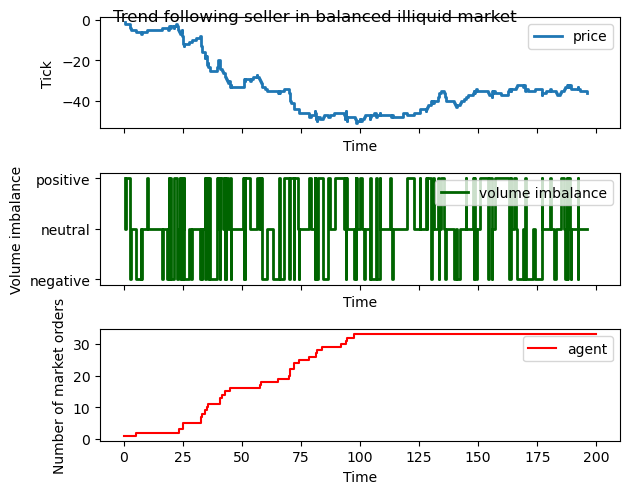

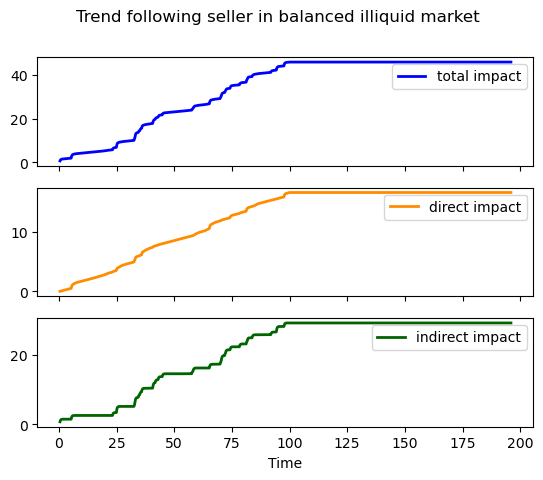

In [11]:
main()